In [71]:
import pandas as pd
pd.set_option('display.max_rows', 250)
pd.set_option('display.width', 1000)
from ENV import *
import gym
from gym import spaces
import numpy as np
import warnings
import torch
from Functions import *
import math

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

_debug = False
_debug_count = 0

from stable_baselines3 import PPO, DQN, A2C, DDPG, TD3
from sb3_contrib import ARS, TQC, QRDQN, MaskablePPO, TRPO, RecurrentPPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import CallbackList, CheckpointCallback, EvalCallback
import pickle, random
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.logger import TensorBoardOutputFormat

# Suppress FutureWarning and UserWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [72]:
# DISCRETE: ars a2c dqn ppo qrdqn rppo trpo mppo
# CONTINVS: ars a2c ddpg ppo rppo sac td3 tqc trpo
# RPPO is slow
algorithm_name = 'trpo'
space_mode = 'discrete'
policy = "MlpPolicy"

TEST = 'long'

dataset_train = 'btc22'
dataset_test = 'btc23'

data_source = loadDataSource(dataset_train, TEST)
try:
  df = pd.read_csv(data_source)
except:
  dat = ((pd.read_csv(f'../data/{dataset_train}.csv',sep=',')).sort_values('date')[['date','open','high','low','close','volume']]).set_index('date')
  getStationary(dat, dataset_train, True)
  data_source = loadDataSource(dataset_train, TEST)
  df = pd.read_csv(data_source)

In [73]:
def getReward(env_, type_):
  if type_ in ['long', 'short']:
    _current_step = env_.current_step
    _df = env_.df
    ema_d = {f'EMA_{ma}' : _df[f'EMA_{ma}'].iloc[_current_step] for ma in EMA}
    ema_sorted = list(ema_d.values())
    ema_sorted.sort()
    ema_vals = [ema_d[f'EMA_{EMA[i]}'] for i in range(len(EMA))]
    # Calculate MA trend score (0 to 1)
    ma_trend_score = (ema_sorted.index(ema_vals[0]) * 0.5 + ema_sorted.index(ema_vals[1]) * 0.3 + ema_sorted.index(ema_vals[2]) * 0.2)
    # Calculate price position relative to MAs
    price_position = (1 - ema_vals[0]) / (ema_vals[2] - ema_vals[0])  # Assuming price (1) is between MA10 and MA50
    REWARD_MULTIPLIER = -0.35
    if type_ == 'long':
      # Calculate reward based on MA trend score and price position
      reward = REWARD_MULTIPLIER * (1.0 - ma_trend_score) * (1.0 - abs(price_position))
    elif type_ == 'short':
      reward = REWARD_MULTIPLIER * ma_trend_score * (1.0 - abs(price_position))
    return reward
  
  if type_ == 'illegal':
    return -0.01
  
  elif type_ in ['close', 'hold']:
    # CHANGE TO: PROFIT FROM THIS ONLY PARTICULAR TRADE
    # ALSO CONSIDER MDD        profit = 0
    lev = 1
    if env_.portfolio['long'] > 0:
      lev = env_.position_leverage['long']
      profit = env_.portfolio['long'] * (env_.current_price - env_.contract_price['long']) * lev
      profit_portion = (env_.current_price - env_.contract_price['long']) / env_.contract_price['long'] * lev
    elif env_.portfolio['short'] > 0:
      lev = env_.position_leverage['short']
      profit = env_.portfolio['short'] * (-env_.current_price + env_.contract_price['short']) * lev
      profit_portion = (-env_.current_price + env_.contract_price['short']) / env_.contract_price['short'] * lev
    else:
      profit = profit_portion = 0

    delta_portfolio = env_.net_worth / INITIAL_ACCOUNT_BALANCE - 1
    delta_benchmark = env_.current_price / env_.initial_price * (1 - TRADING_FEE_CLOSE * lev) - 1 
    REWARD_MULTIPLIER = {'deltas': 2, 'profit' : 2, 'holding': 0.01, 'mdd': 12}
    reward_profitability = REWARD_MULTIPLIER['deltas'] * (delta_benchmark + delta_portfolio) + REWARD_MULTIPLIER['profit'] * profit_portion * profit
    
    if type_ == 'close':
      # MDD Penalty
      mdd_penalty = env_.mdd_previous - env_.mdd
      return reward_profitability - mdd_penalty * math.sqrt(lev)
    
    elif type_ == 'hold':
      # WHEN HOLDING YIELDS MORE PROFIT THAN LAST STEP, THEN PLUS, ELSE MINUS
      reward_history = REWARD_MULTIPLIER['profit'] * (env_.net_worth - env_.previous_net_worth) / env_.previous_net_worth
      
      # WHEN HOLDING IN PROFITABLE POSITION THEN PLUS, ELSE MINUS
      reward_profitability = reward_profitability

      return REWARD_MULTIPLIER['holding'] * (reward_history + reward_profitability - 0.01) * math.sqrt(lev)

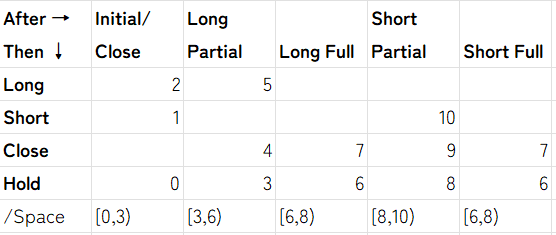

In [74]:
# Action Spaces
action_space_discrete = {
  'initial':  {'space': spaces.Discrete(3 * LEVERAGE), 'offset': 0},
  'open':     {'space': spaces.Discrete(2 * LEVERAGE), 'offset': 6},
}

action_space_continuous = {
  # array[0] ACTIONS
  # array[1] AMOUNT - portion of portfolio, max is 1
  # array[3] SET_TP - later
  # array[4] SET_SL - later
  'initial':       {'space': spaces.Box(low=np.array([0,0]), high=np.array([3,1]), dtype=np.float16), 'offset': 0},
  'open':          {'space': spaces.Box(low=np.array([6,0]), high=np.array([8,1]), dtype=np.float16), 'offset': 0},
  'long_partial':  {'space': spaces.Box(low=np.array([3,0]), high=np.array([6,1]), dtype=np.float16), 'offset': 0},
  'short_partial': {'space': spaces.Box(low=np.array([8,0]), high=np.array([11,1]), dtype=np.float16), 'offset': 0},
}

def isBalanceEnough(balance):
  return balance * (1 - TRADING_FEE_OPEN) < MINIMUM_TRANSACTION_DOLLAR

def translateAction(action_num):
  # Example. Leverage = 5; 
  # 0 1 2 3 4: hold, 5 6 7 8 9: short, etc.
  action_floored = math.floor(action_num / LEVERAGE)
  leverage = math.floor(action_num % LEVERAGE + 1)
  if action_floored in [0, 3, 6, 8]:
    action = 'hold'
  elif action_floored in [4, 7, 9]:
    action = 'close'
  elif action_floored in [2, 5]:
    action = 'long'
  elif action_floored in [1, 10]:
    action = 'short'
  return action, leverage

In [75]:
class TradingEnvironment(gym.Env):
  # metadata = {'render.modes': ['human']}

  def __init__(self, df, algorithm_name, space_mode, evaluate=False):
    super().__init__()

    self.df = df
    self.df['return'] = 0
    self.df['mdd'] = 0
    self.df = add_ema(self.df, True)

    self.initial_price = df['close'].iloc[0]
    
    self.algorithm_name = algorithm_name
    self.space_mode = space_mode # discrete or continuous

    # ACTION space
    self.action_space_mode = 'initial'
    if self.space_mode == 'discrete':
      self.action_space = action_space_discrete['initial']['space']
      self.action_space_offset = action_space_discrete['initial']['offset']
    else:
      self.action_space = action_space_continuous['initial']['space']
      self.action_space_offset = action_space_continuous['initial']['offset']

    # OBSERVATION space
    if self.space_mode == 'discrete':
      # INSIDE
        # ×××××××××× CANCEL [0] CLOSE - last close in value in log USDT
        # [1] VOLUME - in log
        # [2] DELTA - close / open in portion
        # [3] AMPLITUDE - high / low in portion
        # [4] CLOSE_OVER_LOW close / low in portion
        # [5] ema1 over close
        # [6] ema2 over close
        # [7] ema3 over close
      
      # OUTSIDE (only once)
        # [A1] profit movement in log ee8 (current_balance/inital_balance)
        # [A2] benchmark movement ee8 (benchmark_price/initial_price)
      
      # pa = -10 # _price_minimum 10^-10 USDT
      # pb = 10  # _price_maximum 10^10 USDT
      dr = 1 # minimum movement/volume, scaled into [-1, 1]
      ADDITIONAL_FEATURES = ['profit_movement', 'benchmark_movement']
      self.observation_space = spaces.Box(
        #                1   2   3   4   5   6   7
        low= np.append(np.array([-dr,-dr,-dr,-dr,-dr,-dr,-dr] * WINDOW_SIZE), np.array([-dr,-dr])),
        high=np.append(np.array([ dr, dr, dr, dr, dr, dr, dr] * WINDOW_SIZE), np.array([-dr,-dr])),
        shape=(WINDOW_SIZE * LEN_FEATURES + len(ADDITIONAL_FEATURES),),
        dtype=np.float16
      )
    else:
      pass #continuous

    self.EVALUATE_MODE = evaluate
    self.reset()

  def reset(self):
    # Initialization
    self.current_step = 0

    # Balances
    self.balance = INITIAL_ACCOUNT_BALANCE
    self.previous_net_worth = INITIAL_ACCOUNT_BALANCE
    self.net_worth = INITIAL_ACCOUNT_BALANCE
    self.max_net_worth = INITIAL_ACCOUNT_BALANCE
    self.mdd_base = INITIAL_ACCOUNT_BALANCE
    self.min_net_worth = INITIAL_ACCOUNT_BALANCE
    self.mdd = 0
    self.mdd_previous = 0

    # Stats
    self.transactions_count = {'long': 0, 'short': 0}
    self.transaction_fees = {'long': 0, 'short': 0, 'close': 0}
    self.transaction_volume = {'long': 0, 'short': 0, 'close': 0}
    self.transaction_usd_volume = {'long': 0, 'short': 0, 'close': 0}
    self.portfolio = {'long': 0, 'short': 0}
    self.position_leverage = {'long': 1, 'short': 1}
    self.contract_price = {'long': 0, 'short': 0}
    self.leverage = 1

    # Rewards
    self.current_reward = 0
    self.total_reward = 0

    # Statistics for Debug
    self._last_action = 'hold'

    if self.space_mode == 'discrete':
      self.action_space = action_space_discrete['initial']['space']
    else:
      self.action_space = action_space_continuous['initial']['space']

    return self._next_observation()

  def _next_observation(self):
    # Get data points for the last WINDOW_SIZE
    frame_end = self.current_step
    frame_start = frame_end - WINDOW_SIZE
    step = self.current_step
    try:
      current_price = self.df.loc[step, "close"]
    except:
      current_price = self.df.loc[step - 1, "close"]
    obs = np.array([])
    for ft in FEATURES:
      # if loc is negative, then copy frame_end
      for ix in range(frame_start + 1, frame_end + 1):
        _sliced_data = self.df.loc[min(max(ix,0),len(self.df) - 1), ft]
        obs = np.append(obs, _sliced_data)
    
    # Add PROFIT MOVEMENT and BENCHMARK MOVEMENT for the PREVIOUS OBSERVATION     
    
    obs = np.append(obs, [
      np.log(self.net_worth / INITIAL_ACCOUNT_BALANCE) / np.log(10 ** 8) if self.net_worth > 0 else -1, 
      np.log(current_price / self.initial_price) / np.log(10 ** 8) if self.net_worth > 0 else -1
    ])
    return obs
  
  def updatePortoValues(self):
    step = self.current_step
    current_price = self.df.loc[step, "close"]

    _delta_price_long = current_price - self.contract_price['long']
    _delta_price_short = current_price - self.contract_price['short']

    contract_value_long = self.portfolio['long'] * (self.contract_price['long'] + _delta_price_long * self.position_leverage['long'])
    contract_value_short = self.portfolio['short'] * (self.contract_price['short'] + _delta_price_short * self.position_leverage['short'])

    self.previous_net_worth = self.net_worth
    self.net_worth = self.balance + contract_value_long + contract_value_short

    if _debug:
      print(f'NW:{self.net_worth:-9.0f} | BAL:{self.balance:-7.0f} + ', end='')
      print(f'CVL:{contract_value_long:-9.0f} dCPL {_delta_price_long:5.0f} * PFL {self.portfolio["long"]:3.2f} + ',end='')
      print(f'CVS:{contract_value_short:-9.0f} dCPS {_delta_price_short:5.0f} * PFS {self.portfolio["short"]:3.2f} ', end='')
      print(f'ACTION: {self.leverage}× {self.current_action_type}')

    self.max_net_worth = max(self.max_net_worth, self.net_worth)
    if self.net_worth > self.max_net_worth:
      self.mdd_base = self.max_net_worth # set mdd base higher
    else:
      self.mdd_base = min(self.mdd_base, self.net_worth)

    self.min_net_worth = min(self.min_net_worth, self.net_worth)
    self.mdd_previous = self.mdd
    self.mdd = max(1 - self.net_worth/self.max_net_worth, self.mdd)
    self.df.loc[step, 'mdd'] = self.mdd
    self.df.loc[step, 'return'] = (self.net_worth - INITIAL_ACCOUNT_BALANCE) / INITIAL_ACCOUNT_BALANCE

  def handleTakeActionDiscrete(self, action):
    # ------------------------------------------------------------------------- CHANGE SELF.CURRENT_ACTION_TYPE IF FAILED
    step = self.current_step
    current_price = self.df.loc[step, "close"]
    self.current_price = current_price
    self.current_action_type, self.leverage = translateAction(action + self.action_space_offset)

    try:
      self.df.loc[step - 1, 'position']
    except:
      self.current_action_type = 'hold'

    _debug_original_action = self.current_action_type
    force_hold = False

    # ADD  for every change

    # OPEN: LONG/SHORT: if has asset more than trx dollar ===============================================================================================================================
    if (self.current_action_type in ['long', 'short']):
      if self.balance >= MINIMUM_TRANSACTION_DOLLAR and self.portfolio['long'] == 0 and self.portfolio['short'] == 0:
        contracts_opened = round(self.balance / (current_price * (1 + TRADING_FEE_OPEN * self.leverage)), PRECISION) 
        total_cost = contracts_opened * current_price
        fees = contracts_opened * TRADING_FEE_OPEN * self.leverage

        self.balance = self.balance - total_cost - fees
        self.transaction_volume[self.current_action_type] += contracts_opened * self.leverage
        self.transaction_usd_volume[self.current_action_type] += total_cost
        self.transaction_fees[self.current_action_type] += fees
        self.transactions_count[self.current_action_type] += 1
        self.position_leverage[self.current_action_type] = self.leverage
        self.df.loc[step, 'action'] = f'{self.leverage}×{self.current_action_type} {contracts_opened:5f} @ {current_price}'

        # Update porto and return values
        # self.net_worth = self.balance + total_cost
        self.portfolio[self.current_action_type] = contracts_opened
        if step > 0:
          self.df.loc[step, 'position'] = self.df.loc[step - 1, 'position'] + contracts_opened
        else: 
          self.df.loc[step, 'position'] = contracts_opened
        self.portfolio[self.current_action_type] = self.df.loc[step, 'position']
        self.contract_price[self.current_action_type] = current_price

        self.updatePortoValues()

        self.current_reward = getReward(self, self.current_action_type)
      else:
        force_hold = True
        self.updatePortoValues()
        self.current_reward = getReward(self, 'illegal')

    # CLOSE ============================================================================================================================================================================
    if self.current_action_type == 'close':
      if self.df.loc[step - 1, 'position'] * current_price >= MINIMUM_TRANSACTION_DOLLAR and step >= 0:
        units_closed = self.portfolio['long'] + self.portfolio['short']
        fees = units_closed * TRADING_FEE_CLOSE * self.leverage
        
        self.balance += units_closed * current_price - fees
        self.portfolio = {'long': 0, 'short': 0}
        self.position_leverage[self.current_action_type] = 1
        self.df.loc[step, 'position'] = self.df.loc[step - 1, 'position'] - units_closed

        self.transaction_volume[self.current_action_type] += units_closed * self.leverage
        self.transaction_usd_volume[self.current_action_type] += units_closed * current_price
        self.transaction_fees[self.current_action_type] += fees
        
        self.updatePortoValues()

        self.current_reward = getReward(self, 'close')
        
        self.df.loc[self.current_step, 'action'] = f'close {units_closed:5f} @ {current_price}'

      else:
        force_hold = True
        self.updatePortoValues()
        self.current_reward = getReward(self, 'illegal')

    # HOLD ============================================================================================================================================================================
    if force_hold or self.current_action_type == 'hold':
      self.current_action_type = 'hold'
      self.updatePortoValues()
      try: 
        self.df.loc[step, 'position'] = self.df.loc[step - 1, 'position']
      except:
        self.df.loc[step, 'position'] = 0
      self.df.loc[step, 'action'] = 'hold'

      self.current_reward = getReward(self, 'hold')

    # print(action, action_type, self.df.loc[self.current_step, 'position'], self.df.loc[self.current_step, 'action'], self.balance)
    # if step > 0:
    #   print(_debug_original_action, 'hold' if force_hold else self.current_action_type, 
    #         '| REASON: OPEN:', self.balance, '>', MINIMUM_TRANSACTION_DOLLAR, self.portfolio['long'], self.portfolio['short'],
    #         ' CLOSE: ', self.df.loc[step - 1, 'position'] * current_price, '>', MINIMUM_TRANSACTION_DOLLAR, step)
    
    self.df.loc[self.current_step, 'reward'] = self.current_reward
    self.total_reward += self.current_reward

  def handleTakeActionContinuous(self, action):
    current_price = self.df.loc[self.current_step, "close"]
    if action == 0 and self.balance > np.log(MINIMUM_TRANSACTION_DOLLAR):
      pass
    # SHORT
    if action == 1 and self.balance > np.log(MINIMUM_TRANSACTION_DOLLAR):
      pass
    # HOLD
    if action == 2:
      pass
    # CLOSE
    if action == 3:
      pass
  
  def step(self, action):
    # end_ = len(self.df) - WINDOW_SIZE - 1
    end_ = len(self.df)

    if self.space_mode == 'discrete':
      self.handleTakeActionDiscrete(action)
    else:
      self.handleTakeActionContinuous(action)

    self.current_step += 1
    obs = self._next_observation()

    ########################### DYNAMIC ACTION SPACE ////////////////////////////////////////////////////////////////////////////////////////////////////////
    if space_mode == 'discrete':
      portfolio_sellable = self.portfolio['short'] + self.portfolio['long'] > MINIMUM_TRANSACTION_DOLLAR / self.current_price
      if portfolio_sellable: # if has a position
        self.action_space = action_space_discrete['open']['space'] # change to close-hold only
        self.action_space_offset = action_space_discrete['open']['offset']
      else:
        self.action_space = action_space_discrete['initial']['space'] # can do anything
        self.action_space_offset = action_space_discrete['initial']['offset']
    else:
      pass
    
    if self.EVALUATE_MODE:
      done = self.current_step == end_
    else:
      done = self.current_step == int(end_ / getTrainingDivisor(TEST))
      # global _debug_count
      # _debug_count += 1
      # if _debug_count % 15 == 0:
      #   print(_debug, end=' ')
      #   print(self.transactions_count)
    # if (done):
    #   try:
    #     _closing_price = self.df.iloc[self.current_step]['close']
    #   except:
    #     _closing_price = self.df.iloc[self.current_step - 1]['close']
    #   print(f'-------{self.current_step:6d}\n', 
    #         'RW ',  f'{self.total_reward:7.0f}\n', 
    #         'MD ',  f'{self.mdd:.3f}\n', 
    #         'RET ', f'{((self.net_worth - INITIAL_ACCOUNT_BALANCE) / INITIAL_ACCOUNT_BALANCE): 2.3f}\n',
    #         'RVB ', f'{((self.net_worth - INITIAL_ACCOUNT_BALANCE) - _closing_price / self.initial_price):2.3f}\n',
    #         'FIN ', f'{INITIAL_ACCOUNT_BALANCE:7d} → {self.net_worth:7.0f}\n')

    return obs, self.current_reward, done, {}
  
  def render(self, mode='human', close=False):
    # Render the environment to the screen
    profit = self.net_worth - INITIAL_ACCOUNT_BALANCE

    print(f'Step: {self.current_step}')
    print(f'Balance: {self.balance}')
    print(f'Transaction Volume: {self.transaction_volume}')
    print(f'Transaction USD Volume: {self.transaction_usd_volume}')
    print(f'Transaction Fees: {self.transaction_fees}')
    print(f'Transaction Count: {self.transactions_count}')
    
    print(f'Net worth: {self.net_worth} (Max net worth: {self.max_net_worth}, min: {self.min_net_worth})')
    print(f'MDD: {self.mdd}')
    print(f'Profit: {profit}')
    print()

In [76]:
class SummaryWriterCallback(BaseCallback):
    def __init__(self):
      super().__init__()

    def _on_training_start(self):
      self._log_freq = int(len(df) / getTrainingDivisor(TEST))  # log every INTERVAL calls

      output_formats = self.logger.output_formats
      # Save reference to tensorboard formatter object
      # note: the failure case (not formatter found) is not handled here, should be done with try/except.
      self.tb_formatter = next(formatter for formatter in output_formats if isinstance(formatter, TensorBoardOutputFormat))

    def _on_step(self) -> bool:
      # Log my_custom_reward every _log_freq(th) to tensorboard for each environment
      if self.n_calls % self._log_freq == self._log_freq - 1:
        if algorithm_name in ['ars', 'tqc', 'qrdqn', 'mppo', 'trpo', 'rppo']:
          _vars_locals_env = vars(self.locals['self'])
          _vars_locals_env = vars(_vars_locals_env['env'])
        else:
          _vars_locals_env = vars(self.locals['env'])
        _vars_locals_env = vars(_vars_locals_env['envs'][0])
        _vars_locals_env = vars(_vars_locals_env['gym_env'])
        total_reward = _vars_locals_env['total_reward']
        mdd = _vars_locals_env['mdd']
        return_ = _vars_locals_env['net_worth'] / INITIAL_ACCOUNT_BALANCE
        transactions_count_long = _vars_locals_env['transactions_count']['long']
        transactions_count_short = _vars_locals_env['transactions_count']['short']
        # transaction_volume_long = _vars_locals_env['transaction_volume']['long']
        # transaction_volume_short = _vars_locals_env['transaction_volume']['short']
        # print(total_reward, mdd, return_)
      # rewards = self.locals['my_custom_info_dict']['my_custom_reward']
      # for i in range(self.locals['env'].num_envs):
        self.tb_formatter.writer.add_scalar("main/rewards", total_reward, self.n_calls)
        self.tb_formatter.writer.add_scalar("main/mdd", mdd, self.n_calls)
        self.tb_formatter.writer.add_scalar("main/return", return_, self.n_calls)
        self.tb_formatter.writer.add_scalar("trxs/count_long", transactions_count_long, self.n_calls)
        self.tb_formatter.writer.add_scalar("trxs/count_short", transactions_count_short, self.n_calls)
        # self.tb_formatter.writer.add_scalar("trxs/volume_long", transaction_volume_long, self.n_calls)
        # self.tb_formatter.writer.add_scalar("trxs/volume_short", transaction_volume_short, self.n_calls)
      return self.n_calls < len(df) * EPISODE

In [77]:
env = DummyVecEnv([lambda: TradingEnvironment(df, algorithm_name, space_mode)])
# check_env(env)
eval_callback = EvalCallback(env, 
                  best_model_save_path=f"./results/models_/{algorithm_name}_{space_mode}_best_model", 
                  log_path=f"./results/results_/{algorithm_name}_{space_mode}_res", 
                  eval_freq=len(df))
space_mode = space_mode
df = df

if algorithm_name == 'ppo':
  model = PPO(policy, env, verbose=1, tensorboard_log=LOG_LOCATION, device='cpu')
elif algorithm_name == 'dqn':
  model = DQN(policy, env, verbose=1, tensorboard_log=LOG_LOCATION, device='cpu')
elif algorithm_name == 'a2c':
  model = A2C(policy, env, verbose=1, tensorboard_log=LOG_LOCATION, device='cpu')
elif algorithm_name == 'ddpg':
  model = DDPG(policy, env, verbose=1, tensorboard_log=LOG_LOCATION, device='cpu')
elif algorithm_name == 'td3':
  model = TD3(policy, env, verbose=1, tensorboard_log=LOG_LOCATION, device='cpu')
elif algorithm_name == 'ars':
  model = ARS(policy, env, verbose=1, tensorboard_log=LOG_LOCATION, device='cpu')
elif algorithm_name == 'tqc':
  model = TQC(policy, env, verbose=1, tensorboard_log=LOG_LOCATION, device='cpu')
elif algorithm_name == 'qrdqn':
  model = QRDQN(policy, env, verbose=1, tensorboard_log=LOG_LOCATION, device='cpu')
elif algorithm_name == 'mppo':
  model = MaskablePPO(policy, env, verbose=1, tensorboard_log=LOG_LOCATION, device='cpu')
elif algorithm_name == 'trpo':
  model = TRPO(policy, env, verbose=1, tensorboard_log=LOG_LOCATION, device='cpu')
elif algorithm_name == 'rppo':
  model = RecurrentPPO("MlpLstmPolicy", env, verbose=1, tensorboard_log=LOG_LOCATION, device='cpu')

def saveModel():
  # save best model
  model.save(f'./results/models_/model-{algorithm_name}-{space_mode}-{LEN_FEATURES}-{WINDOW_SIZE}-{random.randint(0,99)}')
  pickle.dump({'name': f'{algorithm_name}-{space_mode}', 'data': df}, open(f"'./results/models_/model-{algorithm_name}-{space_mode}-{LEN_FEATURES}-{WINDOW_SIZE}-{random.randint(0,99)}.pkl", 'ab'))

def plot(df=pd.DataFrame([]) ):
  if not df.empty:
    dff = df.head(len(df) - WINDOW_SIZE - 1)
    fig = make_subplots(rows=1, cols=1, specs = [[{"secondary_y": True}]])
    fig.update_layout(autosize=False, width=1300, height=500, title_text=f'{algorithm_name}-{space_mode}')
    initial_price = float(df.head(1)['close'])
    fig.add_trace(go.Scatter( x=dff.index, y=dff['close'] / initial_price, name='Benchmark', legendgroup='1', marker=dict(size=42, color='black')))
    # Portfolio
    fig.add_trace(go.Scatter(x=dff.index,y=dff['return'] + 1,name='Portfolio', marker=dict(size=42,color='red',)))
    # MDD
    fig.add_trace(go.Scatter(x=dff.index,y=-dff['mdd'],name='MDD',marker=dict(size=42,color='blue',),yaxis='y2'))

    fig.update_layout(yaxis_type='log', yaxis2=dict(overlaying='y', side='right'))

    return fig

def evaluate(data_addr, label):
    dat_te = pd.read_csv(data_addr)
    dat_te = dat_te.reset_index(level=0)

    env_te = DummyVecEnv([lambda: TradingEnvironment(dat_te, algorithm_name, space_mode, True)])

    obs_te = env_te.reset()

    for i in range(len(dat_te)):
      if algorithm_name in ['a2c', 'ppo']:
        action, _states = model.predict(obs_te)
      else:
        action, _states = model.predict(obs_te)
      obs_te, rewards, done, info = env_te.step(action)
      if (i + 1) % 500 == 0 or i == len(dat_te) - 1:
        env_te.render()
    
    fig = plot(dat_te)

    return fig

Using cpu device


In [78]:
checkpoint_callback = CheckpointCallback(save_freq=len(df), save_path=f"./results/logs_/{algorithm_name}_{space_mode}_log")
summary_cb = SummaryWriterCallback()
callback = CallbackList([checkpoint_callback, summary_cb])
model.learn(total_timesteps=EPISODE * len(df), log_interval=INTERVAL, callback=callback)


Logging to ./results/logs_\TRPO_8


In [79]:
# res = evaluate('../data/btc23clean.csv', 'btc23')
alter_test = False
evaluate(f'../data/{dataset_test}-{alter_test if alter_test else TEST if TEST else "full"}.csv', dataset_test)


In [87]:
_debug = True
if _debug:
  print(vars(vars(vars(env)['envs'][0])['gym_env'])['df'][:27])
# model.save('results/handpicked_/20240408_weird_spikes')

                date     close    volume     delta  amplitude  close_over_low        return           mdd     EMA_8    EMA_28    EMA_88  position                      action    reward
0   2022.01.01 00:00  46250.00 -0.114160  0.133197  -0.958689       -0.962919  0.000000e+00  0.000000e+00  1.000000  1.000000  1.000000  0.000000                        hold -0.000110
1   2022.01.01 00:01  46312.76 -0.103973  0.145867  -0.927715       -0.930261  0.000000e+00  0.000000e+00  0.998946  0.998738  0.998675  0.000000                        hold -0.000083
2   2022.01.01 00:02  46368.73 -0.059197  0.142935  -0.941531       -0.932471  0.000000e+00  0.000000e+00  0.998242  0.997703  0.997527  0.000000                        hold -0.000059
3   2022.01.01 00:03  46331.08 -0.181063  0.102994  -0.949247       -0.985048 -2.156222e-08  2.156222e-08  0.999264  0.998616  0.998375  2.156222  2×long 2.156222 @ 46331.08  0.018080
4   2022.01.01 00:04  46321.34 -0.267564  0.114902  -0.976262       -0.981025 -4